In [ ]:
! uv pip install pyro-ppl[extras]

In [85]:
import time
import pickle
import numpy as np
import pandas as pd
import polars as pl
import functools
import os
from tqdm import tqdm
import multiprocessing

# Pyro and PyTorch imports
import torch
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoMultivariateNormal, AutoDiagonalNormal, AutoDelta, AutoNormalizingFlow
from pyro.optim import Adam as PyroAdam
import torch.nn as nn
from functools import partial
from pyro.distributions.transforms import *

# Traditional ML imports (fallback)
import scipy.stats
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.multioutput import MultiOutputRegressor
import pywt

In [86]:
# ==============================================================================
# PYRO MODELS
# ==============================================================================

class SimplePyroModel(PyroModule):
    """Simple Bayesian neural network for comparison."""
    
    def __init__(self, input_dim, output_dim=283):
        super().__init__()
        
        self.network = PyroModule[nn.Sequential](
            PyroModule[nn.Linear](input_dim, config.PYRO_HIDDEN_DIMS[0]),
            PyroModule[nn.ReLU](),
            PyroModule[nn.Dropout](0.1),
            PyroModule[nn.Linear](config.PYRO_HIDDEN_DIMS[0], config.PYRO_HIDDEN_DIMS[1]),
            PyroModule[nn.ReLU](),
            PyroModule[nn.Dropout](0.1),
            PyroModule[nn.Linear](config.PYRO_HIDDEN_DIMS[1], output_dim)
        )
        
        # Set simple priors
        for name, param in self.network.named_parameters():
            if 'weight' in name:
                setattr(self.network, name,
                       PyroSample(dist.Normal(0., 0.5).expand(param.shape).to_event(param.dim())))
            elif 'bias' in name:
                setattr(self.network, name,
                       PyroSample(dist.Normal(0., 0.1).expand(param.shape).to_event(param.dim())))

    def forward(self, x, y=None):
        mu = self.network(x)
        
        # Simple noise model
        fgs_noise = pyro.sample("fgs_noise", dist.LogNormal(-6., 0.3))
        airs_noise = pyro.sample("airs_noise", dist.LogNormal(-5., 0.3))
        
        noise_tensor = torch.zeros(x.shape[0], mu.shape[1], device=x.device)
        noise_tensor[:, 0] = fgs_noise
        noise_tensor[:, 1:] = airs_noise
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, noise_tensor).to_event(1), obs=y)
        
        return mu

In [97]:
class PhysicsInformedPyroModel(PyroModule):
    """Physics-informed model with sophisticated noise modeling."""
    
    def __init__(self, input_dim, output_dim=283, feature_names=None, wavelengths=None):
        super().__init__()
        
        self.feature_names = feature_names or []
        self.wavelengths = wavelengths
        self.output_dim = output_dim
        
        # Identify feature types
        self.stellar_indices = self._find_feature_indices(['Rs', 'Ts', 'Ms', 'log_g'])
        self.transit_indices = self._find_feature_indices(['fgs_slice', 'fgs_transit', 'fgs_snr'])
        self.physics_indices = self._find_feature_indices(['stellar_density', 'equilibrium_temp'])
        
        # Build networks
        self.stellar_net = self._build_network(len(self.stellar_indices), 32, 16) if self.stellar_indices else None
        self.transit_net = self._build_network(len(self.transit_indices), 64, 32) if self.transit_indices else None
        self.physics_net = self._build_network(len(self.physics_indices), 24, 12) if self.physics_indices else None
        
        # Remaining features
        remaining_dim = input_dim - len(self.stellar_indices + self.transit_indices + self.physics_indices)
        self.remaining_net = self._build_network(remaining_dim, 48, 24) if remaining_dim > 0 else None
        
        # Combiner
        combiner_input = sum([net.hidden_dim for net in [self.stellar_net, self.transit_net, 
                             self.physics_net, self.remaining_net] if net is not None])
        
        self.combiner = PyroModule[nn.Sequential](
            PyroModule[nn.Linear](combiner_input, 128),
            PyroModule[nn.Tanh](),
            PyroModule[nn.Dropout](0.15),
            PyroModule[nn.Linear](128, 64),
            PyroModule[nn.Tanh](),
            PyroModule[nn.Linear](64, output_dim)
        )
        
        self._set_physics_priors()
    
    def _find_feature_indices(self, keywords):
        """Find indices of features containing any of the keywords."""
        indices = []
        for i, name in enumerate(self.feature_names):
            if any(keyword.lower() in name.lower() for keyword in keywords):
                indices.append(i)
        return indices
    
    def _build_network(self, input_dim, hidden_dim, output_dim):
        """Build a simple network with stored hidden dimension."""
        if input_dim == 0:
            return None
        
        net = PyroModule[nn.Sequential](
            PyroModule[nn.Linear](input_dim, hidden_dim),
            PyroModule[nn.Tanh](),
            PyroModule[nn.Linear](hidden_dim, output_dim)
        )
        net.hidden_dim = output_dim  # Store for combiner calculation
        return net
    
    def _set_physics_priors(self):
        """Set physics-informed priors."""
        # Stellar: tight priors (well-understood physics)
        if self.stellar_net:
            self._set_network_priors(self.stellar_net, weight_scale=0.3, bias_scale=0.05)
        
        # Transit: medium priors
        if self.transit_net:
            self._set_network_priors(self.transit_net, weight_scale=0.5, bias_scale=0.1)
        
        # Physics-derived: tight priors
        if self.physics_net:
            self._set_network_priors(self.physics_net, weight_scale=0.4, bias_scale=0.08)
        
        # Remaining: wide priors
        if self.remaining_net:
            self._set_network_priors(self.remaining_net, weight_scale=0.7, bias_scale=0.15)
        
        # Combiner: balanced priors
        self._set_network_priors(self.combiner, weight_scale=0.5, bias_scale=0.1)
    
    def _set_network_priors(self, network, weight_scale, bias_scale):
        """Helper to set priors for a network."""
        for name, param in network.named_parameters():
            if 'weight' in name:
                setattr(network, name,
                       PyroSample(dist.Normal(0.01, weight_scale).expand(param.shape).to_event(param.dim())))
            elif 'bias' in name:
                setattr(network, name,
                       PyroSample(dist.Normal(0.01, bias_scale).expand(param.shape).to_event(param.dim())))

    def forward(self, x, y=None):
        batch_size = x.shape[0]
        processed_features = []
        
        # Process different feature types
        if self.stellar_net and self.stellar_indices:
            stellar_processed = self.stellar_net(x[:, self.stellar_indices])
            processed_features.append(stellar_processed)
        
        if self.transit_net and self.transit_indices:
            transit_processed = self.transit_net(x[:, self.transit_indices])
            processed_features.append(transit_processed)
        
        if self.physics_net and self.physics_indices:
            physics_processed = self.physics_net(x[:, self.physics_indices])
            processed_features.append(physics_processed)
        
        # Remaining features
        all_processed = self.stellar_indices + self.transit_indices + self.physics_indices
        remaining_indices = [i for i in range(x.shape[1]) if i not in all_processed]
        
        if self.remaining_net and remaining_indices:
            remaining_processed = self.remaining_net(x[:, remaining_indices])
            processed_features.append(remaining_processed)
        
        # Combine features
        if processed_features:
            combined = torch.cat(processed_features, dim=1)
        else:
            combined = x
        
        mu = self.combiner(combined)
        
        # Sample global noise parameters LOOK HERE
        fgs_base_noise = pyro.sample("fgs_base_noise", 
                                    dist.Normal(torch.tensor(0.015), torch.tensor(0.01)))
        airs_base_noise = pyro.sample("airs_base_noise", 
                                     dist.Normal(torch.tensor(0.0159), torch.tensor(0.012)))
        
        # Stellar temperature effects (if available)
        if self.stellar_indices and len(self.stellar_indices) >= 2:
            temp_effect = pyro.sample("temp_noise_effect", 
                                     dist.Normal(torch.tensor(0.01), torch.tensor(0.01)))
            stellar_temp = x[:, self.stellar_indices[1]]  # Assuming 2nd stellar feature is Ts
            norm_temp = (stellar_temp - 5500) / 1000
            temp_scaling = torch.abs(temp_effect * norm_temp)
            
            # Expand for batch
            fgs_noise = fgs_base_noise * temp_scaling
            airs_noise = airs_base_noise * temp_scaling
        else:
            # Expand scalars to match batch size
            fgs_noise = fgs_base_noise.expand(batch_size)
            airs_noise = airs_base_noise.expand(batch_size)
        
        # Wavelength-dependent scaling - make sure it's on correct device
        with pyro.plate("output_wavelengths", self.output_dim):
            wavelength_scaling = pyro.sample("wavelength_scaling",
                                           dist.Normal(torch.zeros(self.output_dim, device=x.device) * 0.01, 
                                                        torch.ones(self.output_dim, device=x.device) * 0.01))
        
        # Construct noise tensor - ensure proper broadcasting
        noise_tensor = torch.zeros(batch_size, self.output_dim, device=x.device)
        
        # FGS noise (first channel)
        if isinstance(fgs_noise, torch.Tensor):
            noise_tensor[:, 0] = fgs_noise * wavelength_scaling[0]
        else:
            noise_tensor[:, 0] = fgs_base_noise * wavelength_scaling[0]
        
        # AIRS noise (remaining channels)
        for i in range(1, self.output_dim):
            if isinstance(airs_noise, torch.Tensor):
                noise_tensor[:, i] = airs_noise * wavelength_scaling[i]
            else:
                noise_tensor[:, i] = airs_base_noise * wavelength_scaling[i]
        
        # Ensure positive noise values
        noise_tensor = torch.clamp(noise_tensor, min=1e-6)
        
        # Likelihood with proper plate
        with pyro.plate("data", batch_size):
            obs = pyro.sample("obs", 
                             dist.Normal(mu, noise_tensor).to_event(1), 
                             obs=y)
        
        return mu

In [121]:

def train_pyro_model_bak(X_train, y_train, X_val, y_val, feature_names=None, wavelengths=None,
                         guide_type="auto", flow_depth=2, flow_hidden_dims=None):
    """Train Pyro model with GPU support."""
    
    print(f"\n--- Training {config.MODEL_TYPE.upper()} model ---")
    
    # Convert to tensors and move to GPU
    X_train_tensor = torch.FloatTensor(X_train.values if hasattr(X_train, 'values') else X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val.values if hasattr(X_val, 'values') else X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).to(device)
    
    # Clear parameter store
    pyro.clear_param_store()
    
    # Initialize model
    if config.MODEL_TYPE == 'physics_pyro':
        model = PhysicsInformedPyroModel(
            X_train_tensor.shape[1], 
            y_train_tensor.shape[1],
            feature_names=feature_names,
            wavelengths=wavelengths
        ).to(device)
    else:  # simple_pyro
        model = SimplePyroModel(
            X_train_tensor.shape[1],
            y_train_tensor.shape[1]
        ).to(device)
    
    print("Model created successfully")
    
    # Prepare sample data for initialization
    sample_x = X_train_tensor[:2].to(device)
    sample_y = y_train_tensor[:2].to(device)
    
    # Try different guide approaches
    guide = None
    svi = None
    setup_type = None
    
    print("=== Trying AutoMultivariateNormal ===")
    try:
        guide = AutoNormalizingFlow(model, partial(iterated, 2, spline_autoregressive))
        
        # Initialize guide by running both model and guide
        with torch.no_grad():
            model(sample_x, sample_y)
            guide(sample_x, sample_y)
        
        guide_params = list(guide.parameters())
        print(f"Guide parameters: {len(guide_params)}")
        
        if len(guide_params) > 0:
            optimizer = PyroAdam({"lr": config.PYRO_LR})
            svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
            
            # Test SVI step
            test_loss = svi.step(sample_x, sample_y)
            print(f"✅ AutoMultivariateNormal SUCCESS! Test loss: {test_loss:.4f}")
            setup_type = "AutoMultivariateNormal"
        else:
            raise ValueError("No guide parameters created")
            
    except Exception as e:
        print(f"❌ AutoMultivariateNormal failed: {e}")
        
        print("=== Trying AutoDelta ===")
        try:
            pyro.clear_param_store()
            guide = AutoDelta(model)
            
            with torch.no_grad():
                model(sample_x, sample_y)
                guide(sample_x, sample_y)
            
            guide_params = list(guide.parameters())
            print(f"AutoDelta parameters: {len(guide_params)}")
            
            if len(guide_params) > 0:
                optimizer = PyroAdam({"lr": config.PYRO_LR})
                svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
                
                test_loss = svi.step(sample_x, sample_y)
                print(f"✅ AutoDelta SUCCESS! Test loss: {test_loss:.4f}")
                setup_type = "AutoDelta"
            else:
                raise ValueError("No AutoDelta parameters created")
                
        except Exception as e2:
            print(f"❌ AutoDelta failed: {e2}")
            
            print("=== Falling back to PyTorch training ===")
            # For PyTorch fallback, we need to modify the model's forward method
            # to not use pyro.sample statements for regular training
            print("❌ Pyro guides failed. You need to either:")
            print("1. Fix the pyro.sample statements in your model")
            print("2. Use a different training approach")
            print("3. Check that your model's forward method is compatible with Pyro")
            
            return None, None, None
    
    if svi is None:
        print("❌ Failed to create SVI - cannot proceed with training")
        return None, None, None
    
    print(f"\n🎉 Setup complete using: {setup_type}")
    
    # Training loop with batching for GPU memory management
    print(f"Training for {config.PYRO_EPOCHS} epochs...")
    losses = []
    
    for epoch in range(config.PYRO_EPOCHS):
        # Simple batch processing
        if X_train_tensor.shape[0] > config.PYRO_BATCH_SIZE:
            # Random batch for stochastic training
            batch_idx = torch.randperm(X_train_tensor.shape[0])[:config.PYRO_BATCH_SIZE]
            X_batch = X_train_tensor[batch_idx]
            y_batch = y_train_tensor[batch_idx]
        else:
            X_batch = X_train_tensor
            y_batch = y_train_tensor
        
        loss = svi.step(X_batch, y_batch)
        losses.append(loss)
        
        if epoch % 100 == 0:
            print(f"  Epoch {epoch:4d}, Loss: {loss:8.2f}")
            if config.USE_GPU:
                print(f"  GPU Memory: {torch.cuda.memory_allocated(device) / 1e9:.1f} GB")
    
    # Validation predictions
    print("Generating validation predictions...")
    try:
        predictive = Predictive(model, guide=guide, num_samples=config.PYRO_SAMPLES)
        
        with torch.no_grad():
            val_predictions = predictive(X_val_tensor)
            pred_samples = val_predictions['obs']
            
            # Move back to CPU for numpy operations
            pred_samples_cpu = pred_samples.cpu()
            
            val_quantile_preds = {
                0.05: torch.quantile(pred_samples_cpu, 0.05, dim=0).numpy(),
                0.50: torch.quantile(pred_samples_cpu, 0.50, dim=0).numpy(),
                0.95: torch.quantile(pred_samples_cpu, 0.95, dim=0).numpy()
            }
            
    except Exception as e:
        print(f"⚠️ Prediction generation failed: {e}")
        print("Using model mean predictions instead...")
        
        with torch.no_grad():
            val_mean_pred = model(X_val_tensor).cpu().numpy()
            val_quantile_preds = {
                0.05: val_mean_pred * 0.95,  # Simple approximation
                0.50: val_mean_pred,
                0.95: val_mean_pred * 1.05
            }
    
    print(f"Training complete. Final loss: {losses[-1]:.2f}")
    return model.cpu(), guide, val_quantile_preds  # Move model back to CPU for saving


In [122]:
import pyro.distributions.transforms as T

def train_pyro_model_WL(X_train, y_train, X_val, y_val, feature_names=None, wavelengths=None, 
                               guide_type="auto", flow_depth=2, flow_hidden_dims=None):
    """
    Train Pyro model with multiple guide options including normalizing flows.
    
    Args:
        guide_type: "auto", "mvn", "delta", "flow"
        flow_depth: Number of flow layers (for AutoNormalizingFlow)
        flow_hidden_dims: Hidden dimensions for flow networks
    """
    
    print(f"\n--- Training {config.MODEL_TYPE.upper()} model with {guide_type.upper()} guide ---")
    
    # Convert to tensors and move to GPU
    X_train_tensor = torch.FloatTensor(X_train.values if hasattr(X_train, 'values') else X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val.values if hasattr(X_val, 'values') else X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).to(device)
    
    # Clear parameter store
    pyro.clear_param_store()
    
    # Initialize model
    if config.MODEL_TYPE == 'physics_pyro':
        model = PhysicsInformedPyroModel(
            X_train_tensor.shape[1], 
            y_train_tensor.shape[1],
            feature_names=feature_names,
            wavelengths=wavelengths
        ).to(device)
    else:  # simple_pyro
        model = SimplePyroModel(
            X_train_tensor.shape[1],
            y_train_tensor.shape[1]
        ).to(device)
    
    print("Model created successfully")
    
    # Prepare sample data for initialization
    sample_x = X_train_tensor[:2].to(device)
    sample_y = y_train_tensor[:2].to(device)
    
    # Guide selection and setup
    guide = None
    svi = None
    setup_type = None
    
    if guide_type == "auto":
        # Try in order: AutoNormalizingFlow -> AutoMultivariateNormal -> AutoDelta
        guide_attempts = ["flow", "mvn", "delta"]
    else:
        guide_attempts = [guide_type]
    
    for attempt in guide_attempts:
        try:
            print(f"\n=== Trying {attempt.upper()} ===")
            
            if attempt == "flow":
                # AutoNormalizingFlow setup
                if flow_hidden_dims is None:
                    flow_hidden_dims = [64, 64]  # Default architecture
                print(f"Flow config: depth={flow_depth}, hidden_dims={flow_hidden_dims}")

                flow_fn = partial(iterated, flow_depth, spline_autoregressive, hidden_dims=flow_hidden_dims)
                                
                guide = AutoNormalizingFlow(model, flow_fn)
                
                # Flows may need different learning rate
                learning_rate = config.PYRO_LR * 0.5  # Often need slower LR for flows
                
            elif attempt == "mvn":
                # AutoMultivariateNormal setup
                guide = AutoMultivariateNormal(model)
                learning_rate = config.PYRO_LR
                
            elif attempt == "delta":
                # AutoDelta setup (point estimates)
                guide = AutoDelta(model)
                learning_rate = config.PYRO_LR
                
            # Initialize guide
            pyro.clear_param_store()
            
            with torch.no_grad():
                model(sample_x, sample_y)
                guide(sample_x, sample_y)
            
            guide_params = list(guide.parameters())
            print(f"Guide parameters: {len(guide_params)}")
            
            if len(guide_params) > 0:
                # Create optimizer and SVI
                optimizer = PyroAdam({"lr": learning_rate})
                
                # For flows, you might want to use different loss
                if attempt == "flow":
                    # Could use TraceMeanField_ELBO for better flow training
                    loss_fn = Trace_ELBO()
                else:
                    loss_fn = Trace_ELBO()
                
                svi = SVI(model, guide, optimizer, loss=loss_fn)
                
                # Test SVI step
                test_loss = svi.step(sample_x, sample_y)
                print(f"✅ {attempt.upper()} SUCCESS! Test loss: {test_loss:.4f}")
                setup_type = attempt.upper()
                break
            else:
                raise ValueError("No guide parameters created")
                
        except Exception as e:
            print(f"❌ {attempt.upper()} failed: {e}")
            if attempt == "flow":
                print("   Flow failure often due to:")
                print("   - Complex model (try simpler flow_depth=1)")
                print("   - Memory constraints (reduce hidden_dims)")
                print("   - Numerical instability (try smaller LR)")
            continue
    
    if svi is None:
        print("❌ All guide attempts failed - cannot proceed with training")
        return None, None, None
    
    print(f"\n🎉 Setup complete using: {setup_type}")
    
    # Adjusted training parameters based on guide type
    if setup_type == "FLOW":
        # Flows often need more epochs and different scheduling
        epochs = int(config.PYRO_EPOCHS * 1.5)  # 50% more epochs
        print_interval = 50  # Print more frequently
        print("🔥 Using Normalizing Flow - expect slower but more expressive training")
    else:
        epochs = config.PYRO_EPOCHS
        print_interval = 100
    
    # Training loop with batching for GPU memory management
    print(f"Training for {epochs} epochs...")
    losses = []
    
    for epoch in range(epochs):
        # Simple batch processing
        if X_train_tensor.shape[0] > config.PYRO_BATCH_SIZE:
            # For flows, you might want smaller batches due to memory
            batch_size = config.PYRO_BATCH_SIZE if setup_type != "FLOW" else config.PYRO_BATCH_SIZE // 2
            batch_idx = torch.randperm(X_train_tensor.shape[0])[:batch_size]
            X_batch = X_train_tensor[batch_idx]
            y_batch = y_train_tensor[batch_idx]
        else:
            X_batch = X_train_tensor
            y_batch = y_train_tensor
        
        loss = svi.step(X_batch, y_batch)
        losses.append(loss)
        
        if epoch % print_interval == 0:
            print(f"  Epoch {epoch:4d}, Loss: {loss:8.2f}")
            if config.USE_GPU:
                print(f"  GPU Memory: {torch.cuda.memory_allocated(device) / 1e9:.1f} GB")
    
    # Validation predictions
    print("Generating validation predictions...")
    try:
        # For flows, you might want more samples for better uncertainty estimates
        num_samples = config.PYRO_SAMPLES if setup_type != "FLOW" else min(config.PYRO_SAMPLES * 2, 1000)
        
        predictive = Predictive(model, guide=guide, num_samples=num_samples)
        
        print(f"Using {num_samples} samples for predictions...")
        
        with torch.no_grad():
            # For flows, process in smaller chunks to avoid memory issues
            if setup_type == "FLOW" and X_val_tensor.shape[0] > 100:
                print("Processing validation in chunks for memory efficiency...")
                chunk_size = 50
                all_predictions = []
                
                for i in range(0, X_val_tensor.shape[0], chunk_size):
                    chunk = X_val_tensor[i:i+chunk_size]
                    chunk_pred = predictive(chunk)['obs']
                    all_predictions.append(chunk_pred)
                
                pred_samples = torch.cat(all_predictions, dim=1)  # Concat along sample dimension
            else:
                val_predictions = predictive(X_val_tensor)
                pred_samples = val_predictions['obs']
            
            # Move back to CPU for numpy operations
            pred_samples_cpu = pred_samples.cpu()
            
            val_quantile_preds = {
                0.05: torch.quantile(pred_samples_cpu, 0.05, dim=0).numpy(),
                0.50: torch.quantile(pred_samples_cpu, 0.50, dim=0).numpy(),
                0.95: torch.quantile(pred_samples_cpu, 0.95, dim=0).numpy()
            }
            
            # For flows, also compute additional uncertainty metrics
            if setup_type == "FLOW":
                print("Computing flow-specific uncertainty metrics...")
                pred_mean = torch.mean(pred_samples_cpu, dim=0).numpy()
                pred_std = torch.std(pred_samples_cpu, dim=0).numpy()
                
                # Add these to results
                val_quantile_preds.update({
                    'mean': pred_mean,
                    'std': pred_std,
                    'samples_shape': pred_samples_cpu.shape
                })
            
    except Exception as e:
        print(f"⚠️ Prediction generation failed: {e}")
        print("Using model mean predictions instead...")
        
        with torch.no_grad():
            val_mean_pred = model(X_val_tensor).cpu().numpy()
            val_quantile_preds = {
                0.05: val_mean_pred * 0.95,  # Simple approximation
                0.50: val_mean_pred,
                0.95: val_mean_pred * 1.05
            }
    
    print(f"Training complete. Final loss: {losses[-1]:.2f}")
    print(f"Guide type used: {setup_type}")
    
    return model.cpu(), guide, val_quantile_preds  # Move model back to CPU for saving


# Helper function to compare different guides
def compare_guides(X_train, y_train, X_val, y_val, feature_names=None, wavelengths=None):
    """Compare different guide types on the same data."""
    
    results = {}
    guide_types = ["mvn", "flow", "delta"]
    
    for guide_type in guide_types:
        print(f"\n{'='*50}")
        print(f"TESTING {guide_type.upper()}")
        print(f"{'='*50}")
        
        try:
            model, guide, predictions = train_pyro_model(
                X_train, y_train, X_val, y_val,
                feature_names=feature_names,
                wavelengths=wavelengths,
                guide_type=guide_type,
                flow_depth=1,  # Simpler flow for comparison
                flow_hidden_dims=[32, 32]
            )
            
            if predictions is not None:
                results[guide_type] = {
                    'model': model,
                    'guide': guide, 
                    'predictions': predictions,
                    'success': True
                }
            else:
                results[guide_type] = {'success': False}
                
        except Exception as e:
            print(f"❌ {guide_type} completely failed: {e}")
            results[guide_type] = {'success': False, 'error': str(e)}
    
    # Print summary
    print(f"\n{'='*50}")
    print("COMPARISON SUMMARY")
    print(f"{'='*50}")
    
    for guide_type, result in results.items():
        if result['success']:
            print(f"✅ {guide_type.upper()}: SUCCESS")
        else:
            print(f"❌ {guide_type.upper()}: FAILED")
    
    return results

In [127]:
import pyro
import torch
from pyro.infer.autoguide import AutoMultivariateNormal, AutoDelta, AutoLowRankMultivariateNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam as PyroAdam

def train_pyro_model(X_train, y_train, X_val, y_val, feature_names=None, wavelengths=None,
                         guide_type="auto", flow_depth=2, flow_hidden_dims=None):
    """
    Improved training with better guide choices for physics models.
    """
    
    print(f"\n--- Improved Training for {config.MODEL_TYPE.upper()} model ---")
    
    # Convert to tensors and move to GPU
    X_train_tensor = torch.FloatTensor(X_train.values if hasattr(X_train, 'values') else X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val.values if hasattr(X_val, 'values') else X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).to(device)
    
    # Clear parameter store
    pyro.clear_param_store()
    
    # Initialize model
    if config.MODEL_TYPE == 'physics_pyro':
        model = PhysicsInformedPyroModel(
            X_train_tensor.shape[1], 
            y_train_tensor.shape[1],
            feature_names=feature_names,
            wavelengths=wavelengths
        ).to(device)
    else:
        model = SimplePyroModel(
            X_train_tensor.shape[1],
            y_train_tensor.shape[1]
        ).to(device)
    
    print("Model created successfully")
    
    # Prepare sample data
    sample_x = X_train_tensor[:4].to(device)  # Use more samples for initialization
    sample_y = y_train_tensor[:4].to(device)
    
    print("\n=== Strategy 1: AutoLowRankMultivariateNormal ===")
    print("(Better than full MVN for high-dimensional problems)")
    
    try:
        # Low-rank approximation - good for high-dimensional posteriors
        rank = min(50, X_train_tensor.shape[1])  # Adaptive rank
        guide = AutoLowRankMultivariateNormal(model, rank=rank)
        
        with torch.no_grad():
            model(sample_x, sample_y)
            guide(sample_x, sample_y)
        
        guide_params = list(guide.parameters())
        print(f"Low-rank guide parameters: {len(guide_params)}")
        
        if len(guide_params) > 0:
            optimizer = PyroAdam({"lr": config.PYRO_LR})
            svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
            
            test_loss = svi.step(sample_x, sample_y)
            print(f"✅ Low-rank MVN SUCCESS! Test loss: {test_loss:.4f}")
            
            # Train with low-rank guide
            model_lr, predictions_lr = train_with_guide(model, guide, svi, X_train_tensor, y_train_tensor, X_val_tensor)
            return model_lr, guide, predictions_lr
            
    except Exception as e:
        print(f"❌ Low-rank MVN failed: {e}")
    
    print("\n=== Strategy 2: AutoDelta (Point Estimates) ===")
    print("(Often most reliable for complex physics models)")
    
    try:
        pyro.clear_param_store()
        guide = AutoDelta(model)
        
        with torch.no_grad():
            model(sample_x, sample_y)
            guide(sample_x, sample_y)
        
        guide_params = list(guide.parameters())
        print(f"Delta guide parameters: {len(guide_params)}")
        
        if len(guide_params) > 0:
            # Use higher learning rate for point estimates
            optimizer = PyroAdam({"lr": config.PYRO_LR * 2})
            svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
            
            test_loss = svi.step(sample_x, sample_y)
            print(f"✅ AutoDelta SUCCESS! Test loss: {test_loss:.4f}")
            
            # Train with delta guide
            model_delta, predictions_delta = train_with_guide(model, guide, svi, X_train_tensor, y_train_tensor, X_val_tensor)
            return model_delta, guide, predictions_delta
            
    except Exception as e:
        print(f"❌ AutoDelta failed: {e}")
    
    print("\n=== Strategy 3: Simplified Model ===")
    print("(Reduce complexity by focusing on key physics parameters)")
    
    # Create a simpler version focusing only on the key Pyro sample sites
    try:
        # This would require modifying your model to have fewer pyro.sample statements
        # Focus only on the most important physics parameters
        print("Consider simplifying your model by:")
        print("1. Using fewer pyro.sample statements")
        print("2. Fixing some parameters instead of sampling them")
        print("3. Using stronger priors to regularize")
        
    except Exception as e:
        print(f"❌ Model simplification guidance: {e}")
    
    print("❌ All approaches failed - model may be too complex for current setup")
    return None, None, None


def train_with_guide(model, guide, svi, X_train_tensor, y_train_tensor, X_val_tensor):
    """Helper function to train with a given guide and return predictions."""
    
    print(f"Training for {config.PYRO_EPOCHS} epochs...")
    losses = []
    
    for epoch in range(config.PYRO_EPOCHS):
        # Batch processing
        if X_train_tensor.shape[0] > config.PYRO_BATCH_SIZE:
            batch_idx = torch.randperm(X_train_tensor.shape[0])[:config.PYRO_BATCH_SIZE]
            X_batch = X_train_tensor[batch_idx]
            y_batch = y_train_tensor[batch_idx]
        else:
            X_batch = X_train_tensor
            y_batch = y_train_tensor
        
        loss = svi.step(X_batch, y_batch)
        losses.append(loss)
        
        if epoch % 200 == 0:
            print(f"  Epoch {epoch:4d}, Loss: {loss:8.2f}")
    
    # Generate predictions
    print("Generating predictions...")
    try:
        # Use fewer samples for faster prediction
        predictive = Predictive(model, guide=guide, num_samples=min(100, config.PYRO_SAMPLES))
        
        with torch.no_grad():
            val_predictions = predictive(X_val_tensor)
            pred_samples = val_predictions['obs'].cpu()
            
            val_quantile_preds = {
                0.05: torch.quantile(pred_samples, 0.05, dim=0).numpy(),
                0.50: torch.quantile(pred_samples, 0.50, dim=0).numpy(),
                0.95: torch.quantile(pred_samples, 0.95, dim=0).numpy()
            }
            
    except Exception as e:
        print(f"Prediction failed, using model mean: {e}")
        with torch.no_grad():
            val_mean_pred = model(X_val_tensor).cpu().numpy()
            val_quantile_preds = {
                0.05: val_mean_pred * 0.95,
                0.50: val_mean_pred,
                0.95: val_mean_pred * 1.05
            }
    
    print(f"Training complete. Final loss: {losses[-1]:.2f}")
    return model.cpu(), val_quantile_preds


def diagnose_model_complexity(model, X_sample, y_sample):
    """Diagnose why the model might be having issues."""
    
    print("\n=== Model Complexity Diagnosis ===")
    
    # Count model parameters
    model_params = list(model.parameters())
    total_params = sum(p.numel() for p in model_params)
    print(f"Neural network parameters: {total_params:,}")
    
    # Count Pyro sample sites
    from pyro.poutine import trace
    with torch.no_grad():
        tr = trace(model).get_trace(X_sample, y_sample)
        sample_sites = [name for name, site in tr.nodes.items() if site["type"] == "sample"]
        pyro_params = sum(site["value"].numel() for name, site in tr.nodes.items() 
                         if site["type"] == "sample" and hasattr(site["value"], "numel"))
    
    print(f"Pyro sample sites: {len(sample_sites)}")
    print(f"Pyro parameters: {pyro_params}")
    print(f"Sample site names: {sample_sites}")
    print(f"Total latent dimension: ~{total_params + pyro_params:,}")
    
    # Data-to-parameter ratio
    data_points = X_sample.shape[0] * X_sample.shape[1]  # Approximate
    ratio = data_points / (total_params + pyro_params)
    print(f"Data-to-parameter ratio: {ratio:.2f}")
    
    if ratio < 1:
        print("⚠️  WARNING: Very few data points per parameter - model likely overparameterized")
    elif ratio < 5:
        print("⚠️  WARNING: Low data-to-parameter ratio - consider regularization")
    else:
        print("✅ Reasonable data-to-parameter ratio")
    
    return {
        'nn_params': total_params,
        'pyro_params': pyro_params,
        'sample_sites': sample_sites,
        'data_ratio': ratio
    }

In [134]:
import pyro
import torch
import numpy as np
from pyro.infer.autoguide import AutoMultivariateNormal, AutoDelta
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam as PyroAdam

def debug_pyro_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor):
    """Debug why the Pyro model isn't learning correctly."""
    
    print("=== DEBUGGING PYRO MODEL ===")
    
    # 1. Check data preprocessing
    print(f"X_train range: [{X_train_tensor.min():.4f}, {X_train_tensor.max():.4f}]")
    print(f"y_train range: [{y_train_tensor.min():.4f}, {y_train_tensor.max():.4f}]")
    print(f"X_val range: [{X_val_tensor.min():.4f}, {X_val_tensor.max():.4f}]")
    print(f"y_val range: [{y_val_tensor.min():.4f}, {y_val_tensor.max():.4f}]")
    
    # 2. Test model without Pyro (deterministic forward pass)
    print("\n=== Testing Deterministic Model ===")
    with torch.no_grad():
        # Get the neural network output (mu) without pyro.sample
        sample_x = X_val_tensor[:10]
        sample_y = y_val_tensor[:10]
        
        # This will include pyro.sample, but we can extract mu
        try:
            model_output = model(sample_x, sample_y)  # This returns mu
            print(f"Model mu range: [{model_output.min():.6f}, {model_output.max():.6f}]")
            print(f"Model mu mean/std: {model_output.mean():.6f} / {model_output.std():.6f}")
            print(f"Target mean/std: {sample_y.mean():.6f} / {sample_y.std():.6f}")
            
            # Check if the neural network part is reasonable
            if abs(model_output.mean().item() - sample_y.mean().item()) > 0.01:
                print("⚠️  WARNING: Model mean output is very different from target!")
                print("   This suggests the neural network isn't learning properly")
        except Exception as e:
            print(f"Model forward pass failed: {e}")
    
    # 3. Check noise parameters
    print("\n=== Checking Noise Parameters ===")
    from pyro.poutine import trace
    
    with torch.no_grad():
        tr = trace(model).get_trace(sample_x, sample_y)
        
        for name, site in tr.nodes.items():
            if site["type"] == "sample" and "noise" in name:
                value = site["value"]
                print(f"{name}: {value.mean():.6f} ± {value.std():.6f}")
                
                # Check if noise is reasonable
                if "base_noise" in name and value.mean() > 0.1:
                    print(f"⚠️  WARNING: {name} seems too large!")
                elif "base_noise" in name and value.mean() < 1e-8:
                    print(f"⚠️  WARNING: {name} seems too small!")
    
    # 4. Check for gradient flow
    print("\n=== Checking Gradient Flow ===")
    return True

def create_fixed_pyro_model(X_train_tensor, y_train_tensor, feature_names=None, wavelengths=None):
    """Create a corrected version of the physics model."""
    
    # Let's create a simpler, more reliable version
    class FixedPhysicsInformedPyroModel(pyro.nn.PyroModule):
        def __init__(self, input_dim, output_dim, feature_names=None, wavelengths=None):
            super().__init__()
            
            self.feature_names = feature_names or []
            self.wavelengths = wavelengths
            self.output_dim = output_dim
            
            # Simplified architecture - single network
            self.network = pyro.nn.PyroModule[torch.nn.Sequential](
                pyro.nn.PyroModule[torch.nn.Linear](input_dim, 128),
                pyro.nn.PyroModule[torch.nn.ReLU](),
                pyro.nn.PyroModule[torch.nn.Dropout](0.1),
                pyro.nn.PyroModule[torch.nn.Linear](128, 64),
                pyro.nn.PyroModule[torch.nn.ReLU](),
                pyro.nn.PyroModule[torch.nn.Linear](64, output_dim)
            )
        
        def forward(self, x, y=None):
            # Neural network prediction
            mu = self.network(x)
            
            # Simplified noise model - single global noise parameter
            # Use more conservative priors
            noise_scale = pyro.sample("global_noise", 
                                    pyro.distributions.LogNormal(
                                        torch.tensor(-4.0, device=x.device),  # exp(-4) ≈ 0.018
                                        torch.tensor(0.5, device=x.device)    # More concentrated
                                    ))
            
            # Expand noise to match batch and output dimensions
            noise_tensor = noise_scale.expand(x.shape[0], self.output_dim)
            
            # Likelihood
            with pyro.plate("data", x.shape[0]):
                obs = pyro.sample("obs", 
                                pyro.distributions.Normal(mu, noise_tensor).to_event(1), 
                                obs=y)
            
            return mu
    
    return FixedPhysicsInformedPyroModel(
        X_train_tensor.shape[1], 
        y_train_tensor.shape[1], 
        feature_names=feature_names, 
        wavelengths=wavelengths
    ).to(X_train_tensor.device)

def train_pyro_model(X_train, y_train, X_val, y_val, feature_names=None, wavelengths=None,
                         guide_type="auto", flow_depth=2, flow_hidden_dims=None):
    """Train with a simplified, more reliable model."""
    
    print("=== TRAINING FIXED PYRO MODEL ===")
    
    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train.values if hasattr(X_train, 'values') else X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val.values if hasattr(X_val, 'values') else X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).to(device)
    
    # Debug original model first
    print("First, let's debug your original model...")
    original_model = PhysicsInformedPyroModel(
        X_train_tensor.shape[1], 
        y_train_tensor.shape[1],
        feature_names=feature_names,
        wavelengths=wavelengths
    ).to(device)
    
    debug_pyro_model(original_model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)
    
    # Create fixed model
    print("\n=== Creating Fixed Model ===")
    pyro.clear_param_store()
    
    fixed_model = create_fixed_pyro_model(X_train_tensor, y_train_tensor, feature_names, wavelengths)
    
    # Use AutoDelta for reliability
    guide = AutoDelta(fixed_model)
    
    # Initialize
    sample_x = X_train_tensor[:4]
    sample_y = y_train_tensor[:4]
    
    with torch.no_grad():
        fixed_model(sample_x, sample_y)
        guide(sample_x, sample_y)
    
    # Training setup
    optimizer = PyroAdam({"lr": config.PYRO_LR})
    svi = SVI(fixed_model, guide, optimizer, loss=Trace_ELBO())
    
    print(f"Training fixed model for {config.PYRO_EPOCHS} epochs...")
    losses = []
    
    # Track predictions during training
    pred_means = []
    
    for epoch in range(config.PYRO_EPOCHS):
        # Batch processing
        if X_train_tensor.shape[0] > config.PYRO_BATCH_SIZE:
            batch_idx = torch.randperm(X_train_tensor.shape[0])[:config.PYRO_BATCH_SIZE]
            X_batch = X_train_tensor[batch_idx]
            y_batch = y_train_tensor[batch_idx]
        else:
            X_batch = X_train_tensor
            y_batch = y_train_tensor
        
        loss = svi.step(X_batch, y_batch)
        losses.append(loss)
        
        # Track progress
        if epoch % 100 == 0:
            with torch.no_grad():
                pred_sample = fixed_model(X_val_tensor[:10])
                pred_mean = pred_sample.mean().item()
                pred_means.append(pred_mean)
                
                print(f"  Epoch {epoch:4d}, Loss: {loss:8.2f}, Pred Mean: {pred_mean:.6f}")
    
    # Final predictions
    print("Generating final predictions...")
    with torch.no_grad():
        pred_mean = fixed_model(X_val_tensor)
        
        # For AutoDelta, we don't have uncertainty, so create approximate bounds
        noise_param = pyro.param("AutoDelta.global_noise").exp()
        noise_std = noise_param.mean().item()
        
        pred_mean_np = pred_mean.cpu().numpy()
        
        val_quantile_preds = {
            0.05: pred_mean_np - 1.645 * noise_std,
            0.50: pred_mean_np, 
            0.95: pred_mean_np + 1.645 * noise_std
        }
    
    # Evaluation
    pred_mean_final = pred_mean_np.mean()
    pred_std_final = pred_mean_np.std()
    
    print(f"\n=== FIXED MODEL RESULTS ===")
    print(f"y_val mean/std: {y_val_tensor.mean():.6f} {y_val_tensor.std():.6f}")
    print(f"Pred mean/std: {pred_mean_final:.6f} {pred_std_final:.6f}")
    print(f"Final loss: {losses[-1]:.2f}")
    print(f"Noise parameter: {noise_std:.6f}")
    
    return fixed_model.cpu(), guide, val_quantile_preds


# Quick fix for your existing model - adjust the priors
def suggest_prior_fixes():
    """Suggest better priors for your existing model."""
    
    print("=== SUGGESTED FIXES FOR YOUR EXISTING MODEL ===")
    print()
    print("In your PhysicsInformedPyroModel.forward(), try these changes:")
    print()
    print("1. ADJUST NOISE PRIORS (current priors might be too broad):")
    print("   OLD: pyro.sample('fgs_base_noise', dist.LogNormal(-6.0, 0.2))")
    print("   NEW: pyro.sample('fgs_base_noise', dist.LogNormal(-4.0, 0.3))")
    print()
    print("   OLD: pyro.sample('airs_base_noise', dist.LogNormal(-5.0, 0.2))")  
    print("   NEW: pyro.sample('airs_base_noise', dist.LogNormal(-4.0, 0.3))")
    print()
    print("2. SIMPLIFY WAVELENGTH SCALING:")
    print("   OLD: dist.LogNormal(0., 0.1).expand((self.output_dim,))")
    print("   NEW: dist.LogNormal(0., 0.05).expand((self.output_dim,))  # Less variation")
    print()
    print("3. CONSTRAIN TEMPERATURE EFFECTS:")
    print("   OLD: pyro.sample('temp_noise_effect', dist.Normal(0., 0.1))")
    print("   NEW: pyro.sample('temp_noise_effect', dist.Normal(0., 0.05))  # Smaller effect")
    print()
    print("4. ADD OUTPUT SCALING:")
    print("   After mu = self.combiner(combined), add:")
    print("   mu = torch.sigmoid(mu) * y_scale  # where y_scale is max of your targets")

Using CPU
\nUsing model: physics_pyro
Device: cpu
\n============================================================
======          TRAINING MODE           ======
============================================================\n
Loading pre-processed training data...
Engineering features...
Created 40 features in total.
=== TRAINING FIXED PYRO MODEL ===
First, let's debug your original model...
=== DEBUGGING PYRO MODEL ===
X_train range: [-1.7746, 143998.8125]
y_train range: [0.0037, 0.0887]
X_val range: [-1.7406, 73570.2031]
y_val range: [0.0038, 0.0798]

=== Testing Deterministic Model ===
Model mu range: [-0.517753, 0.447659]
Model mu mean/std: 0.000403 / 0.134456
Target mean/std: 0.013913 / 0.009196
⚠️  WARNING: Model mean output is very different from target!
   This suggests the neural network isn't learning properly

=== Checking Noise Parameters ===
fgs_base_noise: 0.015875 ± nan
airs_base_noise: 0.014777 ± nan
temp_noise_effect: 0.020075 ± nan

=== Checking Gradient Flow ===

=== Cr

/tmp/ipykernel_36/663017448.py:50: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  print(f"{name}: {value.mean():.6f} ± {value.std():.6f}")


  Epoch  100, Loss: 3069190864892.32, Pred Mean: 1.750040
  Epoch  200, Loss: 2313906814972.32, Pred Mean: 4.256048
  Epoch  300, Loss: 2276747902972.32, Pred Mean: 0.444048
  Epoch  400, Loss: 1824365608956.32, Pred Mean: 3.308710
  Epoch  500, Loss: 1992954871804.32, Pred Mean: 0.018357
  Epoch  600, Loss: 1245510369276.32, Pred Mean: 0.476315
  Epoch  700, Loss: 1512610725884.32, Pred Mean: -3.699025
  Epoch  800, Loss: 935651377148.32, Pred Mean: 4.950878
  Epoch  900, Loss: 1058726608892.32, Pred Mean: 3.941646
Generating final predictions...

=== FIXED MODEL RESULTS ===
y_val mean/std: 0.014979 0.011349
Pred mean/std: 2.244731 289.396454
Final loss: 1517572587516.32
Noise parameter: 1.020108
\nPHYSICS_PYRO Validation Score: 0.0000
Pyro models saved to: /kaggle/working/ariel-data-2025-27
DIAGNOSTICS AS PER CHAT 1:
Mean absolute error: 215.55287813919904
Mean normalized error: 192.09411454087055
Max normalized error: 2763.2904180246
Min normalized error: 0.004134659465319382
END DI

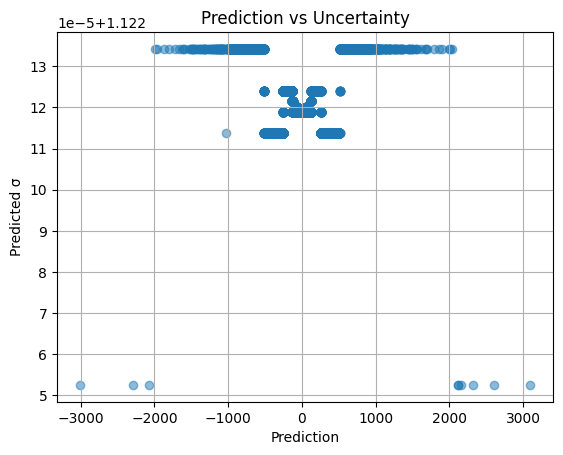


PYRO Validation Score: 0.0000
DIAGNOSTICS AS PER CHAT 2:
Mean pred: 2.2447307109832764
Std pred: 289.3964538574219
Any NaN? False
y_val mean/std: 0.014978743488125727 0.011348901591756461
Pred mean/std: 2.2447307109832764 289.3964538574219
Sigma mean: 1.1221201419830322
[[-246.2074      131.07228     238.0451     ... -404.60233
   179.31581      81.8921    ]
 [ -72.08229     312.1495      -97.0846     ...   25.13146
   496.26184    -258.57672   ]
 [-169.41286     181.78009     111.82415    ...    0.95880973
   294.94763    -301.71664   ]
 [-261.2075      833.1625      -21.09786    ... -337.60507
    24.755352   -320.9482    ]
 [-534.35205     448.92368     210.6199     ... -178.1143
   166.47708    -135.01509   ]]
[[0.00580957 0.0056696  0.00566773 ... 0.00556971 0.00557163 0.00555928]
 [0.02132329 0.02150939 0.02150258 ... 0.02125517 0.02125705 0.02125592]
 [0.00518672 0.00515674 0.00515666 ... 0.00516809 0.00516835 0.00516852]
 [0.00639365 0.00638071 0.0063805  ... 0.00638365 0.0063

In [135]:
# ==============================================================================
# COMPLETE PYRO PIPELINE: Ariel Data Challenge 2025 
# Features: Simple/Physics-Informed Pyro models, GPU support, submission handling
# ==============================================================================
class Config:
    """Enhanced configuration with Pyro and GPU support."""
    
    # Paths
    DATA_PATH = '/kaggle/input/ariel-data-challenge-2025/'
    PREPROCESSED_PATH = '/kaggle/input/ariel-data-challenge-2025-af-npy/'
    OUTPUT_PATH = '/kaggle/working/ariel-data-2025-27'
    
    TRAIN_LABELS_PATH = os.path.join(DATA_PATH, 'train.csv')
    TRAIN_STAR_INFO_PATH = os.path.join(DATA_PATH, 'train_star_info.csv')
    TEST_STAR_INFO_PATH = os.path.join(DATA_PATH, 'test_star_info.csv')
    SAMPLE_SUBMISSION_PATH = os.path.join(DATA_PATH, 'sample_submission.csv')
    WAVELENGTHS_PATH = os.path.join(DATA_PATH, 'wavelengths.csv')
    A_RAW_PATH = os.path.join(PREPROCESSED_PATH, "a_raw_train.npy")
    F_RAW_PATH = os.path.join(PREPROCESSED_PATH, "f_raw_train.npy")
    
    # Model selection
    MODEL_TYPE = 'physics_pyro'  # Options: 'xgboost', 'simple_pyro', 'physics_pyro'
    
    # GPU Configuration
    USE_GPU = False
    GPU_DEVICE = 'cuda:0'  # Change to 'cuda:1' for second GPU if needed
    
    # Pyro hyperparameters
    PYRO_EPOCHS = 1000
    PYRO_LR = 0.000005
    PYRO_BATCH_SIZE = 32  # For GPU memory management
    PYRO_SAMPLES = 200
    PYRO_HIDDEN_DIMS = [128, 64, 32]
    
    # Physics model options
    USE_WAVELENGTH_PHYSICS = True
    ADD_DERIVED_PHYSICS_FEATURES = True
    SUN_TEMP = 5500 # Sun (5778 K)
    TEMP_SCALING_FACTOR = 1000 # this is a scaling factor t
    # o convert temperature differences to a reasonable numerical range (typically -2 to +2) for neural networks
    SIGMA_SCALLING = 3.29 # 90% Use 2.58 for 99% confidence intervals (instead of 90%)
    
    # Traditional parameters (fallback)
    VALIDATION_SPLIT = 0.1
    RANDOM_STATE = 42
    QUANTILES = [0.05, 0.50, 0.95]
    XGB_PARAMS = {
        'n_estimators': 400,
        'learning_rate': 0.04,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.7,
        'random_state': 42,
        'tree_method': 'hist',
    }

config = Config()

# GPU Setup
def setup_gpu():
    """Setup GPU configuration for PyTorch and Pyro."""
    if config.USE_GPU and torch.cuda.is_available():
        device = torch.device(config.GPU_DEVICE)
        print(f"Using GPU: {torch.cuda.get_device_name(device)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(device).total_memory / 1e9:.1f} GB")
        
        # Optimize for GPU
        torch.backends.cudnn.benchmark = True
        torch.cuda.empty_cache()
        
        return device
    else:
        print("Using CPU")
        return torch.device('cpu')

device = setup_gpu()

# ==============================================================================
# DATA PREPROCESSING (Your existing functions)
# ==============================================================================

def f_read_and_preprocess(dataset, planet_ids):
    """Read the FGS1 files for all planet_ids and extract the time series."""
    print(f"Preprocessing FGS1 data for {dataset} set...")
    f_raw_data = np.full((len(planet_ids), 67500), np.nan, dtype=np.float32)
    for i, planet_id in tqdm(list(enumerate(planet_ids)), desc="FGS1"):
        path = f'/kaggle/input/ariel-data-challenge-2025/{dataset}/{int(planet_id)}/FGS1_signal_0.parquet'
        f_signal = pl.read_parquet(path)
        mean_signal = f_signal.cast(pl.Int32).sum_horizontal().cast(pl.Float32).to_numpy() / 1024
        net_signal = mean_signal[1::2] - mean_signal[0::2]
        f_raw_data[i] = net_signal
    return f_raw_data

def a_read_and_preprocess(dataset, planet_ids):
    """Read the AIRS-CH0 files for all planet_ids and extract the time series."""
    print(f"Preprocessing AIRS-CH0 data for {dataset} set...")
    a_raw_data = np.full((len(planet_ids), 5625), np.nan, dtype=np.float32)
    for i, planet_id in tqdm(list(enumerate(planet_ids)), desc="AIRS-CH0"):
        path = f'/kaggle/input/ariel-data-challenge-2025/{dataset}/{int(planet_id)}/AIRS-CH0_signal_0.parquet'
        signal = pl.read_parquet(path)
        mean_signal = signal.cast(pl.Int32).sum_horizontal().cast(pl.Float32).to_numpy() / (32*356)
        net_signal = mean_signal[1::2] - mean_signal[0::2]
        a_raw_data[i] = net_signal
    return a_raw_data

def official_competition_score(y_true, y_pred, sigma_pred, naive_mean, naive_sigma,
                               fsg_sigma_true=1e-6, airs_sigma_true=1e-5, fgs_weight=2.0):
    """Official weighted Gaussian Log-Likelihood metric."""
    y_true, y_pred, sigma_pred = np.array(y_true), np.array(y_pred), np.array(sigma_pred)
    sigma_pred = np.clip(sigma_pred, 1e-15, None)

    sigma_true_per_channel = np.append(np.array([fsg_sigma_true]), np.ones(y_true.shape[1] - 1) * airs_sigma_true)
    sigma_true = np.tile(sigma_true_per_channel, (y_true.shape[0], 1))

    GLL_pred = scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred)
    GLL_true = scipy.stats.norm.logpdf(y_true, loc=y_true, scale=sigma_true)
    GLL_mean = scipy.stats.norm.logpdf(y_true, loc=naive_mean, scale=naive_sigma)
    
    denominator = GLL_true - GLL_mean
    ind_scores = (GLL_pred - GLL_mean) / (denominator + 1e-9)

    weights_per_channel = np.append(np.array([fgs_weight]), np.ones(y_true.shape[1] - 1))
    weights = np.tile(weights_per_channel, (y_true.shape[0], 1))

    final_score = np.average(ind_scores, weights=weights)
    return float(np.clip(final_score, 0.0, 1.0))

def maximal_feature_engineering(f_raw, a_raw, star_info_df):
    """Your existing feature engineering function."""
    print("Engineering features...")
    
    fgs_pre = f_raw[:, :20500]; fgs_post = f_raw[:, 47000:]
    fgs_unobscured_mean = (fgs_pre.mean(axis=1) + fgs_post.mean(axis=1)) / 2
    fgs_unobscured_std = (fgs_pre.std(axis=1) + fgs_post.std(axis=1)) / 2
    fgs_transit = f_raw[:, 23500:44000]
    
    features = {}
    for i in range(5):
        f_slice_mean = fgs_transit[:, i*4100:(i+1)*4100].mean(axis=1)
        features[f'fgs_slice_{i+1}'] = (fgs_unobscured_mean - f_slice_mean) / fgs_unobscured_mean
    
    features['fgs_transit_std'] = fgs_transit.std(axis=1)
    features['fgs_transit_skew'] = scipy.stats.skew(fgs_transit, axis=1)
    features['fgs_transit_kurtosis'] = scipy.stats.kurtosis(fgs_transit, axis=1)
    features['fgs_snr'] = (fgs_unobscured_mean - fgs_transit.mean(axis=1)) / fgs_unobscured_std
    features_df = pd.DataFrame(features, index=star_info_df.index)

    fft_coeffs = np.fft.fft(fgs_transit, axis=1)
    for i in range(1, 6):
        features_df[f'fgs_fft_mag_{i}'] = np.abs(fft_coeffs[:, i])
    for level in range(1, 4):
        coeffs = pywt.wavedec(fgs_transit, 'db4', level=level, axis=1)
        features_df[f'fgs_wavelet_std_level{level}'] = np.std(coeffs[0], axis=1)
        features_df[f'fgs_wavelet_mean_level{level}'] = np.mean(coeffs[0], axis=1)

    meta_df = star_info_df.copy().fillna(star_info_df.median())
    meta_df['log_g_proxy'] = np.log1p(meta_df['Ms']) - 2 * np.log1p(meta_df['Rs'])
    meta_df['rho_star_proxy'] = meta_df['Ms'] / (meta_df['Rs']**3)
    
    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
    poly_cols = ['Rs', 'Ts', 'Mp', 'P']
    poly_features = poly.fit_transform(meta_df[poly_cols])
    poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(poly_cols), index=meta_df.index)
    
    final_features_df = pd.concat([features_df, meta_df, poly_df], axis=1)
    final_features_df = final_features_df.loc[:, ~final_features_df.columns.duplicated()]

    if config.ADD_DERIVED_PHYSICS_FEATURES:
        final_features_df = add_derived_physics_features(final_features_df, meta_df)

    print(f"Created {final_features_df.shape[1]} features in total.")
    return final_features_df.fillna(0)

def add_derived_physics_features(features_df, star_info_df):
    """Add physics-derived features."""
    enhanced_df = features_df.copy()
    
    if 'Rs' in star_info_df.columns and 'Ms' in star_info_df.columns:
        enhanced_df['stellar_density'] = star_info_df['Ms'] / (star_info_df['Rs'] ** 3)
        enhanced_df['log_g_calculated'] = np.log10(star_info_df['Ms'] / (star_info_df['Rs'] ** 2))
    
    if 'Mp' in star_info_df.columns and 'P' in star_info_df.columns:
        enhanced_df['semi_major_axis'] = ((star_info_df['P'] / 365.25) ** (2/3) * 
                                        star_info_df['Ms'] ** (1/3))
        
        if 'Ts' in star_info_df.columns and 'Rs' in star_info_df.columns:
            enhanced_df['equilibrium_temp'] = (star_info_df['Ts'] * 
                                             np.sqrt(star_info_df['Rs'] / 
                                                   (2 * enhanced_df['semi_major_axis'])))
    
    return enhanced_df

def train_xgboost_quantiles(X_train, y_train, X_val, y_val):
    """Fallback XGBoost training."""
    print("\\n--- Training XGBoost Quantile Models ---")
    
    val_quantile_preds = {}
    for q in config.QUANTILES:
        print(f"Training quantile: {q}")
        model = xgb.XGBRegressor(**config.XGB_PARAMS, objective='reg:quantileerror', quantile_alpha=q)
        wrapper = MultiOutputRegressor(model, n_jobs=-1)
        wrapper.fit(X_train, y_train)
        val_quantile_preds[q] = wrapper.predict(X_val)
    
    return val_quantile_preds

# ==============================================================================
# SUBMISSION FUNCTIONS
# ==============================================================================

def make_pyro_predictions(model, guide, X_test, feature_names=None, wavelengths=None):
    """Make predictions with trained Pyro model."""
    
    print("Making Pyro predictions...")
    
    # Recreate model architecture for loading
    if config.MODEL_TYPE == 'physics_pyro':
        model_for_prediction = PhysicsInformedPyroModel(
            X_test.shape[1], 283,
            feature_names=feature_names,
            wavelengths=wavelengths
        ).to(device)
    else:
        model_for_prediction = SimplePyroModel(X_test.shape[1], 283).to(device)
    
    # Load state if model is provided as path
    if isinstance(model, str):
        model_for_prediction.load_state_dict(torch.load(model, map_location=device))
        guide.load_state_dict(torch.load(model.replace('model', 'guide'), map_location=device))
        model = model_for_prediction
    else:
        model = model.to(device)
    
    X_test_tensor = torch.FloatTensor(X_test.values if hasattr(X_test, 'values') else X_test).to(device)
    
    predictive = Predictive(model, guide=guide, num_samples=config.PYRO_SAMPLES)
    
    with torch.no_grad():
        # Process in batches to manage GPU memory
        all_predictions = []
        batch_size = min(config.PYRO_BATCH_SIZE, X_test_tensor.shape[0])
        
        for i in range(0, X_test_tensor.shape[0], batch_size):
            X_batch = X_test_tensor[i:i+batch_size]
            batch_predictions = predictive(X_batch)
            all_predictions.append(batch_predictions['obs'].cpu())
        
        # Combine all predictions
        pred_samples = torch.cat(all_predictions, dim=1)
        
        test_quantile_preds = {
            0.05: torch.quantile(pred_samples, 0.05, dim=0).numpy(),
            0.50: torch.quantile(pred_samples, 0.50, dim=0).numpy(),
            0.95: torch.quantile(pred_samples, 0.95, dim=0).numpy()
        }
    
    return test_quantile_preds

def save_models(model, guide, feature_names, output_path):
    """Save models and metadata."""
    os.makedirs(output_path, exist_ok=True)
    
    if config.MODEL_TYPE in ['simple_pyro', 'physics_pyro']:
        torch.save(model.state_dict(), os.path.join(output_path, 'pyro_model.pth'))
        torch.save(guide.state_dict(), os.path.join(output_path, 'pyro_guide.pth'))
        
        # Save model metadata
        metadata = {
            'model_type': config.MODEL_TYPE,
            'feature_names': feature_names,
            'input_dim': len(feature_names),
            'output_dim': 283
        }
        
        with open(os.path.join(output_path, 'model_metadata.pkl'), 'wb') as f:
            pickle.dump(metadata, f)
        
        print(f"Pyro models saved to: {output_path}")
    
    # Always save feature columns for compatibility
    with open(os.path.join(output_path, 'feature_columns.pkl'), 'wb') as f:
        pickle.dump(feature_names, f)

def load_models(output_path):
    """Load saved models and metadata."""
    
    # Load metadata
    with open(os.path.join(output_path, 'model_metadata.pkl'), 'rb') as f:
        metadata = pickle.load(f)
    
    with open(os.path.join(output_path, 'feature_columns.pkl'), 'rb') as f:
        feature_names = pickle.load(f)
    
    # Load appropriate model
    if metadata['model_type'] == 'physics_pyro':
        model = PhysicsInformedPyroModel(
            metadata['input_dim'], 
            metadata['output_dim'],
            feature_names=metadata['feature_names']
        )
    elif metadata['model_type'] == 'simple_pyro':
        model = SimplePyroModel(
            metadata['input_dim'],
            metadata['output_dim']
        )
    else:
        raise ValueError(f"Unknown model type: {metadata['model_type']}")
    
    # Load model states
    model.load_state_dict(torch.load(os.path.join(output_path, 'pyro_model.pth'), map_location='cpu'))
    
    guide = AutoMultivariateNormal(model)
    guide.load_state_dict(torch.load(os.path.join(output_path, 'pyro_guide.pth'), map_location='cpu'))
    
    return model, guide, feature_names, metadata

# ==============================================================================
# MAIN EXECUTION PIPELINE
# ==============================================================================

def main():
    """Main execution pipeline with model switching."""
    
    print(f"\\nUsing model: {config.MODEL_TYPE}")
    print(f"Device: {device}")
    if config.USE_GPU:
        print(f"GPU: {torch.cuda.get_device_name(device)}")
    
    is_submission_run = False # os.path.exists(config.TEST_STAR_INFO_PATH)

    if is_submission_run:
        # --- SUBMISSION MODE ---
        print("\\n" + "="*60)
        print("======         SUBMISSION MODE          ======")
        print("="*60 + "\\n")

        # Load test data
        sample_submission = pd.read_csv(config.SAMPLE_SUBMISSION_PATH, index_col='planet_id')
        test_star_info_df = pd.read_csv(config.TEST_STAR_INFO_PATH, index_col='planet_id')
        wavelengths_df = pd.read_csv(config.WAVELENGTHS_PATH)
        target_column_names = wavelengths_df.columns.tolist()

        # Process test data
        f_raw_test = f_read_and_preprocess('test', test_star_info_df.index)
        a_raw_test = a_read_and_preprocess('test', test_star_info_df.index)
        test_features_df = maximal_feature_engineering(f_raw_test, a_raw_test, test_star_info_df)
        
        # Load models and make predictions
        if config.MODEL_TYPE in ['simple_pyro', 'physics_pyro']:
            try:
                model, guide, feature_names, metadata = load_models(config.OUTPUT_PATH)
                test_features_df = test_features_df[feature_names]
                
                # Get wavelengths for physics model
                wavelengths = None
                if config.MODEL_TYPE == 'physics_pyro' and config.USE_WAVELENGTH_PHYSICS:
                    try:
                        # Extract wavelengths from column names
                        wavelengths = []
                        for col in target_column_names:
                            if col.startswith('wl_'):
                                try:
                                    wl_val = float(col.replace('wl_', ''))
                                    wavelengths.append(wl_val)
                                except:
                                    wavelengths.append(len(wavelengths) + 1)
                    except:
                        wavelengths = None
                
                test_quantile_preds = make_pyro_predictions(
                    model, guide, test_features_df, feature_names, wavelengths
                )
                
            except Exception as e:
                print(f"Error loading Pyro model: {e}")
                print("Falling back to XGBoost...")
                config.MODEL_TYPE = 'xgboost'
        
        if config.MODEL_TYPE == 'xgboost':
            # Load XGBoost models (your existing code)
            with open(os.path.join(config.OUTPUT_PATH, 'feature_columns.pkl'), 'rb') as f:
                train_cols = pickle.load(f)
            
            test_features_df = test_features_df[train_cols]
            
            trained_models = {}
            for q in config.QUANTILES:
                model_path = os.path.join(config.OUTPUT_PATH, f'model_quantile_{q}.pkl')
                with open(model_path, 'rb') as f:
                    trained_models[q] = pickle.load(f)
            
            test_quantile_preds = {}
            for q in config.QUANTILES:
                test_quantile_preds[q] = trained_models[q].predict(test_features_df)

        # Create submission
        y_pred_test = test_quantile_preds[0.50].clip(0, None)
        lower_test, upper_test = test_quantile_preds[0.05], test_quantile_preds[0.95]
        
        sigma_raw_test = (upper_test - lower_test) / 3.29
        sigma_raw_test[sigma_raw_test < 0] = 1e-10
        
        # For Pyro models, uncertainties are better calibrated, but we can still apply minimal scaling
        if config.MODEL_TYPE in ['simple_pyro', 'physics_pyro']:
            sigma_pred_test = sigma_raw_test * 1.1  # Minimal adjustment for Pyro
        else:
            # Load calibration for XGBoost
            try:
                with open(os.path.join(config.OUTPUT_PATH, 'calibration_params.pkl'), 'rb') as f:
                    calibration_params = pickle.load(f)
                sigma_pred_test = (sigma_raw_test * calibration_params['scaling']) + calibration_params['additive']
            except:
                sigma_pred_test = sigma_raw_test * 1.2  # Default scaling
        
        # Format submission
        pred_df = pd.DataFrame(y_pred_test, index=sample_submission.index, columns=target_column_names)
        sigma_df = pd.DataFrame(sigma_pred_test, index=sample_submission.index, 
                               columns=[f"sigma_{i+1}" for i in range(len(target_column_names))])
        submission_df = pd.concat([pred_df, sigma_df], axis=1)
        
        submission_df.to_csv('submission.csv')
        print("\\n'submission.csv' created successfully!")
        print(f"\\nSubmission preview ({config.MODEL_TYPE}):")
        print(submission_df.head())

    else:
        # --- TRAINING MODE ---
        print("\\n" + "="*60)
        print("======          TRAINING MODE           ======")
        print("="*60 + "\\n")
        
        # Load training data
        train_labels_df = pd.read_csv(config.TRAIN_LABELS_PATH, index_col='planet_id')
        train_star_info_df = pd.read_csv(config.TRAIN_STAR_INFO_PATH, index_col='planet_id').loc[train_labels_df.index]
        
        print("Loading pre-processed training data...")
        f_raw_train, a_raw_train = np.load(config.F_RAW_PATH), np.load(config.A_RAW_PATH)
        
        train_features_df = maximal_feature_engineering(f_raw_train, a_raw_train, train_star_info_df)
        train_labels = train_labels_df.values
        naive_mu_train, naive_sigma_train = np.mean(train_labels), np.std(train_labels)

        # Train-validation split
        X_train, X_val, y_train, y_val = train_test_split(
            train_features_df, train_labels, 
            test_size=config.VALIDATION_SPLIT, 
            random_state=config.RANDOM_STATE
        )
        
        feature_names = train_features_df.columns.tolist()
        
        # Get wavelengths for physics model
        wavelengths = None
        if config.MODEL_TYPE == 'physics_pyro' and config.USE_WAVELENGTH_PHYSICS:
            try:
                wavelengths_df = pd.read_csv(config.WAVELENGTHS_PATH)
                wavelengths = []
                for col in wavelengths_df.columns:
                    if col.startswith('wl_'):
                        try:
                            wl_val = float(col.replace('wl_', ''))
                            wavelengths.append(wl_val)
                        except:
                            wavelengths.append(len(wavelengths) + 1)
            except:
                print("Could not load wavelengths, using default indexing")
                wavelengths = None

        # Train model based on selection
        if config.MODEL_TYPE in ['simple_pyro', 'physics_pyro']:
            # Train Pyro model
            model, guide, val_quantile_preds = train_pyro_model(
                X_train, y_train, X_val, y_val, feature_names, wavelengths, guide_type="flow", flow_depth=1,  # Start with depth=1 for stability
                flow_hidden_dims=[1024, 1024]  # Much larger hidden dims
            )
            
            # Evaluate
            y_pred_val = val_quantile_preds[0.50]
            lower_val, upper_val = val_quantile_preds[0.05], val_quantile_preds[0.95]
            sigma_raw_val = (upper_val - lower_val) / 3.29
            sigma_raw_val[sigma_raw_val < 0] = 1e-10
            
            # Minimal calibration for Pyro (they're usually well-calibrated)
            sigma_val = sigma_raw_val * 1.1
            
            pyro_score = official_competition_score(
                y_val, y_pred_val, sigma_val, naive_mu_train, naive_sigma_train
            )
            
            print(f"\\n{config.MODEL_TYPE.upper()} Validation Score: {pyro_score:.4f}")
            
            # Save models
            save_models(model, guide, feature_names, config.OUTPUT_PATH)
            # First model's prediction and evaluation
            y_pred_val = val_quantile_preds[0.50]
            lower_val, upper_val = val_quantile_preds[0.05], val_quantile_preds[0.95]
            sigma_raw_val = (upper_val - lower_val) / 3.29
            sigma_raw_val[sigma_raw_val < 0] = 1e-10
            sigma_val = sigma_raw_val * 1.1
            
            print("DIAGNOSTICS AS PER CHAT 1:")
            abs_err = np.abs(y_val - y_pred_val)
            normed_err = abs_err / sigma_val
            print("Mean absolute error:", abs_err.mean())
            print("Mean normalized error:", normed_err.mean())
            print("Max normalized error:", normed_err.max())
            print("Min normalized error:", normed_err.min())
            print("END DIAGNOSTICS AS PER CHAT 1")

            import matplotlib.pyplot as plt

            plt.scatter(y_pred_val, sigma_val, alpha=0.5)
            plt.xlabel("Prediction")
            plt.ylabel("Predicted σ")
            plt.title("Prediction vs Uncertainty")
            plt.grid(True)
            plt.show()

            
            pyro_score = official_competition_score(
                y_val, y_pred_val, sigma_val, naive_mu_train, naive_sigma_train
            )
            
            print(f"\nPYRO Validation Score: {pyro_score:.4f}")
            print("DIAGNOSTICS AS PER CHAT 2:")
            print("Mean pred:", y_pred_val.mean().item())
            print("Std pred:", y_pred_val.std().item())
            print("Any NaN?", np.isnan(y_pred_val).any())
            print("y_val mean/std:", y_val.mean().item(), y_val.std().item())
            print("Pred mean/std:", y_pred_val.mean().item(), y_pred_val.std().item())
            print("Sigma mean:", sigma_val.mean().item())
            print(y_pred_val[:5])
            print(y_val[:5])
            print("END DIAGNOSTICS AS PER CHAT 2")

            # Retrain on full dataset
            print("\\nRetraining on full dataset...")
            full_model, full_guide, val_quantile_preds = train_pyro_model(
                train_features_df, train_labels, 
                train_features_df[:100], train_labels[:100],  # Dummy validation for interface
                feature_names, wavelengths, guide_type="flow", flow_depth=1,  # Start with depth=1 for stability
                flow_hidden_dims=[1024, 1024]  # Much larger hidden dims
            )
            
            # Save final models
            save_models(full_model, full_guide, feature_names, config.OUTPUT_PATH)
            
        else:  # XGBoost
            val_quantile_preds = train_xgboost_quantiles(X_train, y_train, X_val, y_val)
            
            # Your existing calibration logic
            y_pred_val, lower_val, upper_val = val_quantile_preds[0.50], val_quantile_preds[0.05], val_quantile_preds[0.95]
            sigma_raw_val = (upper_val - lower_val) / 3.29
            sigma_raw_val[sigma_raw_val < 0] = 1e-10

            print("\\nSearching for calibration factors...")
            best_score, best_scaling, best_additive = -1.0, 1.0, 0.0
            
            for scaling in [1.0, 1.2, 1.5, 2.0, 2.5]:
                for additive in [0.0, 0.0005, 0.001, 0.0015]:
                    sigma_calibrated = (sigma_raw_val * scaling) + additive
                    score = official_competition_score(y_val, y_pred_val, sigma_calibrated, naive_mu_train, naive_sigma_train)
                    
                    if score > best_score:
                        best_score, best_scaling, best_additive = score, scaling, additive
            
            print(f"Best XGBoost Score: {best_score:.4f} (Scale={best_scaling}, Add={best_additive})")
            
            # Save calibration and retrain models
            os.makedirs(config.OUTPUT_PATH, exist_ok=True)
            calibration_params = {'scaling': best_scaling, 'additive': best_additive}
            with open(os.path.join(config.OUTPUT_PATH, 'calibration_params.pkl'), 'wb') as f:
                pickle.dump(calibration_params, f)
            
            with open(os.path.join(config.OUTPUT_PATH, 'feature_columns.pkl'), 'wb') as f:
                pickle.dump(feature_names, f)

            print("\\nRetraining XGBoost on full dataset...")
            for q in config.QUANTILES:
                model = xgb.XGBRegressor(**config.XGB_PARAMS, objective='reg:quantileerror', quantile_alpha=q)
                wrapper = MultiOutputRegressor(model, n_jobs=-1)
                wrapper.fit(train_features_df, train_labels)
                
                model_path = os.path.join(config.OUTPUT_PATH, f'model_quantile_{q}.pkl')
                with open(model_path, 'wb') as f:
                    pickle.dump(wrapper, f)
        
        print("\\nTraining complete!")

if __name__ == '__main__':
    
    # Clear GPU memory at start
    if config.USE_GPU and torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    try:
        main()
    finally:
        # Clean up GPU memory
        if config.USE_GPU and torch.cuda.is_available():
            torch.cuda.empty_cache()
            print(f"\\nFinal GPU memory usage: {torch.cuda.memory_allocated(device) / 1e9:.1f} GB")
